# Snapshot Ensemble

## Import libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

import uncertainty_toolbox as uct

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from matplotlib import pyplot as plt  

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras import backend
import os
from math import pi, cos, floor

warnings.simplefilter(action='ignore')

2022-08-22 09:57:43.175842: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-22 09:57:43.181913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 09:57:43.181928: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load and Preprocess data

In [2]:
data = pd.read_excel("../../../Data/dense_data.xlsx")
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])
X_encoded = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=0.2)

In [3]:
print(f" The Data size : {X_encoded.shape} \n  X_train : {X_train.shape} \n  y_train : {y_train.shape}")
print(f" \n  X_test : {X_test.shape} \n  y_test : {y_test.shape}")

 The Data size : (7314, 426) 
  X_train : (5851, 426) 
  y_train : (5851,)
 
  X_test : (1463, 426) 
  y_test : (1463,)


## Callbacks And Scheduler

In [4]:
# snapshot ensemble with custom learning rate schedule
class SnapshotEnsemble(Callback):
    # constructor
    def __init__(self, n_epochs, n_cycles, lrate_max, verbose=0):
        self.epochs = n_epochs
        self.cycles = n_cycles
        self.lr_max = lrate_max
        self.lrates = list()

    # calculate learning rate for epoch - the learning rate scheduler.
    def cosine_annealing(self, epoch, n_epochs, n_cycles, lrate_max):
        epochs_per_cycle = floor(n_epochs/n_cycles)
        cos_inner = (pi * (epoch % epochs_per_cycle)) / (epochs_per_cycle)
        return lrate_max/2 * (cos(cos_inner) + 1)

    # calculate and set learning rate at the start of the epoch
    def on_epoch_begin(self, epoch, logs={}):
        # calculate learning rate
        lr = self.cosine_annealing(epoch, self.epochs, self.cycles, self.lr_max)
        # set learning rate
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrates.append(lr)

    # save models at the end of each cycle
    def on_epoch_end(self, epoch, logs={}):
        if not os.path.exists('models/'):
            os.makedirs('models/')
        # check if we can save model
        epochs_per_cycle = floor(self.epochs / self.cycles)
        if epoch != 0 and (epoch + 1) % epochs_per_cycle == 0:
            # save model to file
            filename = "models/snapshot_model_%d.h5" % int((epoch + 1) / epochs_per_cycle)
            self.model.save(filename)
            print('>saved snapshot %s, epoch %d' % (filename, epoch))

## Define Model 

In [5]:
#Let's define our Neural Networks 
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='relu'))
opt = Adam(0.001)
model.compile(loss='mse', optimizer=opt, metrics=['mae'])

2022-08-22 09:57:53.890513: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 09:57:53.890567: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 09:57:53.890607: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-e044432): /proc/driver/nvidia/version does not exist
2022-08-22 09:57:53.891615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
n_epochs = 1000 # Number of epochs 
n_cycles = n_epochs / 50 # Number of cycles eg : Number of snapshots to make
ca = SnapshotEnsemble(n_epochs, n_cycles, 0.01) # Instantiate the Snaptchot class

In [7]:
#TRAIN THE Nn_cyclesL NET
print("START TRAINING ...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=n_epochs, verbose=0, callbacks=[ca])
print("DONE !")

START TRAINING ...
>saved snapshot models/snapshot_model_1.h5, epoch 49
>saved snapshot models/snapshot_model_2.h5, epoch 99
>saved snapshot models/snapshot_model_3.h5, epoch 149
>saved snapshot models/snapshot_model_4.h5, epoch 199
>saved snapshot models/snapshot_model_5.h5, epoch 249
>saved snapshot models/snapshot_model_6.h5, epoch 299
>saved snapshot models/snapshot_model_7.h5, epoch 349
>saved snapshot models/snapshot_model_8.h5, epoch 399
>saved snapshot models/snapshot_model_9.h5, epoch 449
>saved snapshot models/snapshot_model_10.h5, epoch 499
>saved snapshot models/snapshot_model_11.h5, epoch 549
>saved snapshot models/snapshot_model_12.h5, epoch 599
>saved snapshot models/snapshot_model_13.h5, epoch 649
>saved snapshot models/snapshot_model_14.h5, epoch 699
>saved snapshot models/snapshot_model_15.h5, epoch 749
>saved snapshot models/snapshot_model_16.h5, epoch 799
>saved snapshot models/snapshot_model_17.h5, epoch 849
>saved snapshot models/snapshot_model_18.h5, epoch 899
>s

## Load Snapshot models

In [8]:
# load models from file
def load_all_models(nb_models):
    all_models = list()
    for i in range(nb_models):
        # define filename for this ensemble
        filename = 'models/snapshot_model_' + str(i + 1) + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [9]:
nb_models = int(n_cycles)
print(nb_models)

20


In [10]:
# reverse loaded models so we build the ensemble with the last models first
members = load_all_models(nb_models)
print('Loaded %d models' % len(members))
members = list(reversed(members))
# evaluate different numbers of ensembles on hold out set
single_scores, ensemble_scores = list(), list()

>loaded models/snapshot_model_1.h5
>loaded models/snapshot_model_2.h5
>loaded models/snapshot_model_3.h5
>loaded models/snapshot_model_4.h5
>loaded models/snapshot_model_5.h5
>loaded models/snapshot_model_6.h5
>loaded models/snapshot_model_7.h5
>loaded models/snapshot_model_8.h5
>loaded models/snapshot_model_9.h5
>loaded models/snapshot_model_10.h5
>loaded models/snapshot_model_11.h5
>loaded models/snapshot_model_12.h5
>loaded models/snapshot_model_13.h5
>loaded models/snapshot_model_14.h5
>loaded models/snapshot_model_15.h5
>loaded models/snapshot_model_16.h5
>loaded models/snapshot_model_17.h5
>loaded models/snapshot_model_18.h5
>loaded models/snapshot_model_19.h5
>loaded models/snapshot_model_20.h5
Loaded 20 models


## Evaluate Models

In [11]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
	# select a subset of members
	subset = members[:n_members]
	# make prediction
	yhat = ensemble_predictions(subset, testX)
	# calculate accuracy
	return mean_absolute_error(testy, yhat)

In [12]:
def ensemble_predictions(members, X_test):
    # make predictions
    preds = [model.predict(X_test) for model in members]
    preds = np.array(preds)
    preds = preds.reshape(len(members), X_test.shape[0])
    # average all predictions
    mean_pred = np.mean(preds, axis=0)
    # stds := uncertainty 
    stdv = np.std(preds, axis=0)
    return preds, mean_pred, stdv 

In [13]:
# Make predicitons on "test" data using M=10 Snapshot models  
preds, mean_pred, stds = ensemble_predictions(members, X_test)

# Make predicitons on "test" data using M=10 Snapshot models  
train_preds, train_mean_pred, train_stds = ensemble_predictions(members, X_train)

183/183 [==============================] - 0s 1ms/step


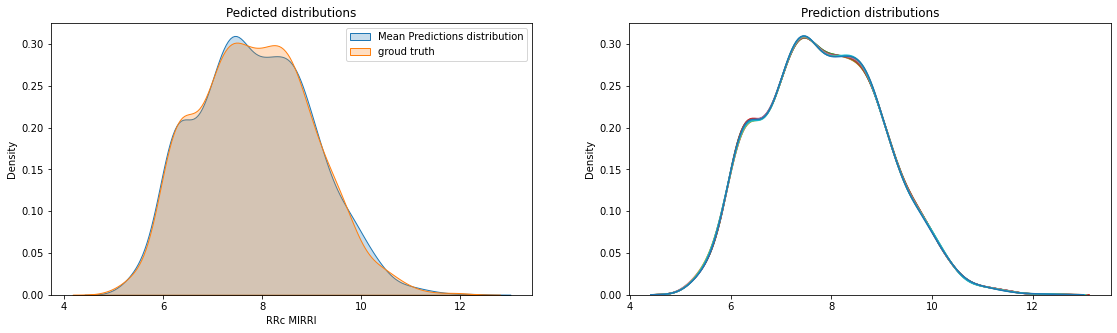

In [14]:
plt.figure(figsize=(19,5))
plt.subplot(1,2,1)
#sns.kdeplot(prediction_distribution[0], shade=True)
sns.kdeplot(mean_pred, shade=True)
sns.kdeplot(y_test, shade=True)
plt.legend(['Mean Predictions distribution','groud truth'])
plt.title('Pedicted distributions')
plt.subplot(1,2,2)
for i in range(10):
    sns.kdeplot(preds[i], shade=False)
    i = i+1
sns.kdeplot(mean_pred, shade=False)
plt.title('Prediction distributions')

plt.show()

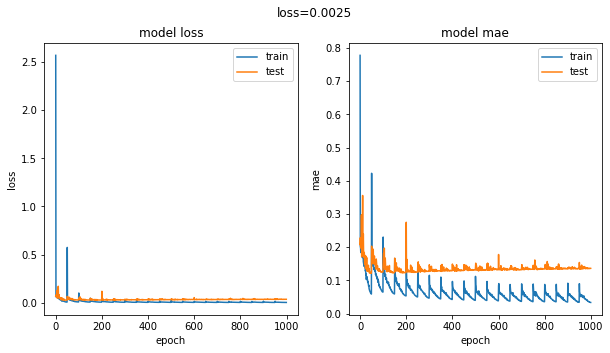

In [15]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.suptitle("loss={:5.4f}".format(history.history["loss"][-1]))

plt.show()

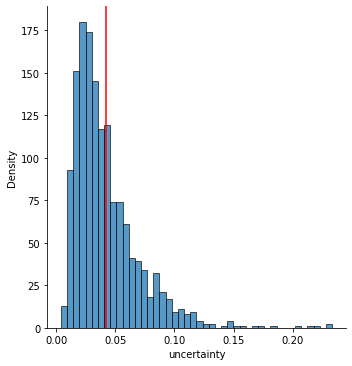

In [16]:
#plt.figure(figsize=(10,8))
sns.displot(stds)
plt.axvline(np.mean(stds), color='red')
#plt.legend(['mean of stdvs','std for each tire preds'])
plt.xlabel("uncertainty")
plt.ylabel("Density")
plt.show()

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

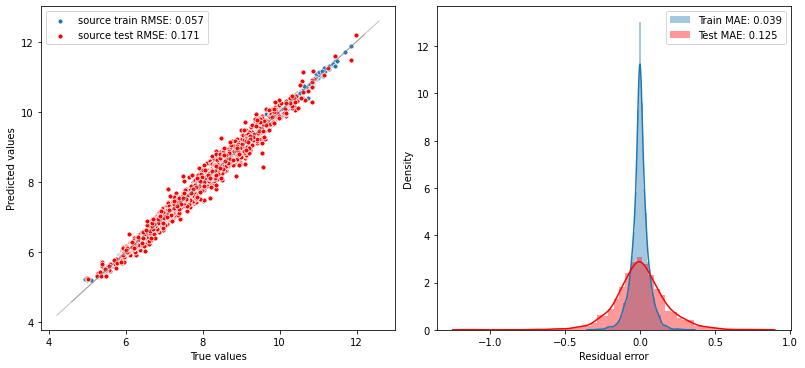

In [17]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]);ax2 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, train_mean_pred, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, mean_pred, label='source test', ax=ax1, plot_line=True, score='RMSE', color='red')

plot_residuals(y_train, train_mean_pred, kind='hist', label='Train', ax=ax2, score='MAE')
plot_residuals(y_test, mean_pred, kind='hist', label='Test', ax=ax2, score='MAE', color ='red')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

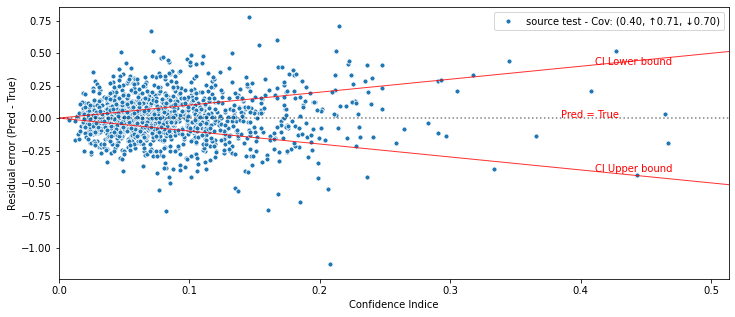

In [18]:
plot_confidence_v2(y_test,mean_pred , mean_pred-2*stds,  mean_pred+2*stds, label='source test')

In [19]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(mean_pred), np.array(stds), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds))

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

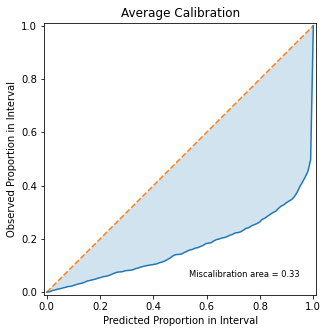

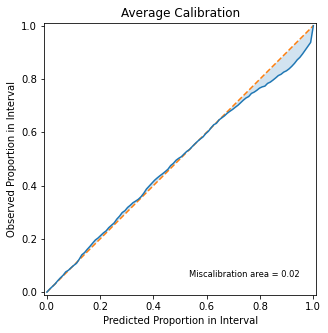

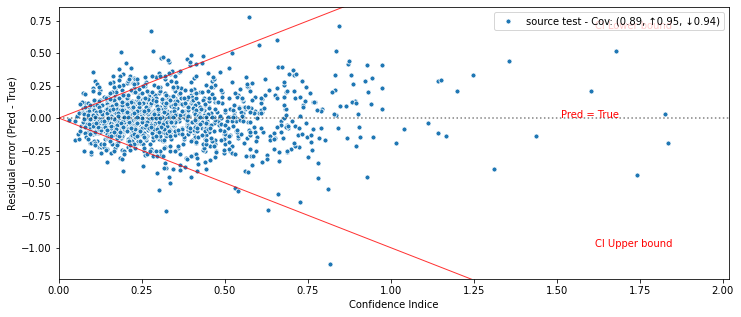

In [20]:
uct.viz.plot_calibration(np.array(mean_pred),  np.array(stds) , np.array(y_test))
uct.viz.plot_calibration(np.array(mean_pred),  np.array(new_stds) , np.array(y_test))
plot_confidence_v2(y_test,np.array(mean_pred) ,np.array(mean_pred)-2*new_stds, np.array(mean_pred)+2*new_stds, label='source test')

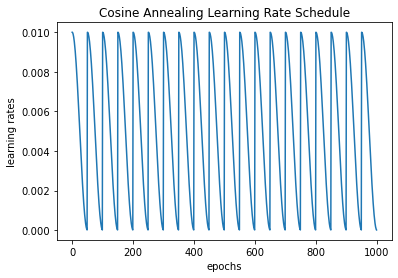

In [21]:
# plot learning rate
plt.plot(ca.lrates)
plt.title("Cosine Annealing Learning Rate Schedule")
plt.xlabel("epochs")
plt.ylabel("learning rates")
plt.show()

## Metrics Summary

In [22]:
all_metrics_calib = uct.metrics.get_all_metrics(np.array(mean_pred), np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.125
  RMSE          0.171
  MDAE          0.094
  MARPD         1.578
  R2            0.978
  Correlation   0.989
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.028
  Mean-absolute Calibration Error       0.018
  Miscalibration Area                   0.018
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.051
     Group Size: 0.56 -- Calibration Error: 0.025
     Group Size: 1.00 -- Calibration Error: 0.018
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.060
     Group Size: 0.56 -- Calibration Error: 0.035
     Group Size: 1.00 -- Calibration Error: 0.028
================

### Save metrics

In [23]:
import pickle

with open('Snapshot_metrics_dense.pkl', 'wb') as f:
    pickle.dump(all_metrics_calib, f)